**Table of contents**<a id='toc0_'></a>    
- 1. [Load results   ](#toc1_)    
- 2. [Results for a set of parameters   ](#toc2_)    
  - 2.1. [Region by region  ](#toc2_1_)    
  - 2.2. [Global  ](#toc2_2_)    
- 3. [Compute correlation coefficient with uncertainty using bootstrapping ](#toc3_)    
- 4. [Compute correlation coefficients for all sets of parameters](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
import numpy as np
import pickle

from scipy.stats import multivariate_normal, pearsonr

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as fx
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

In [2]:
# Confidence ellipses
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpatches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# 1. <a id='toc1_'></a>Load results    [&#128285;](#toc0_)

In [3]:
# Nankai (main) results
nank2 = pickle.load(open('../results/nankai/nank2_synch.pkl', 'rb'))

nank2_corr_lengths = nank2['corr_lengths']
nank2_n_eqs = nank2['n_felt_eqs']
nank2_n_trms = nank2['n_tremors']
nank2_n_trm_min = nank2['parameters']['min_n_tremor_dx10km'] 

In [4]:
# Nankai (secondary) results
nank = pickle.load(open('../results/nankai/nank_synch.pkl', 'rb'))

nank_corr_lengths = nank['corr_lengths']
nank_n_eqs = nank['n_felt_eqs']
nank_n_trms = nank['n_tremors']
nank_n_trm_min = nank['parameters']['min_n_tremor_dx10km']

In [5]:
# Nankai (LFEs) results
nank_lfe = pickle.load(open('../results/nankai/nank_lfe_synch.pkl', 'rb'))

nank_lfe_corr_lengths = nank_lfe['corr_lengths']
nank_lfe_n_eqs = nank_lfe['n_felt_eqs']
nank_lfe_n_trms = nank_lfe['n_tremors']
nank_lfe_n_trm_min = nank_lfe['parameters']['min_n_tremor_dx10km']

In [6]:
# Japan trench results
jpt = pickle.load(open('../results/jptrench/jpt_synch.pkl', 'rb'))

jpt_corr_lengths = jpt['corr_lengths']
jpt_n_eqs = jpt['n_felt_eqs']
jpt_n_trms = jpt['n_tremors']

jpt_n_trm_min = jpt['parameters']['min_n_tremor_dx10km']

In [7]:
# Cascadia results
casc = pickle.load(open('../results/cascadia/casc_synch.pkl', 'rb'))

casc_corr_lengths = casc['corr_lengths']
casc_n_eqs = casc['n_felt_eqs']
casc_n_trms = casc['n_tremors']

In [8]:
# Alaska results
ak = pickle.load(open('../results/alaska/ak_synch.pkl', 'rb'))

ak_corr_lengths = ak['corr_lengths']
ak_n_eqs = ak['n_felt_eqs']
ak_n_trms = ak['n_tremors']

In [9]:
# Parkfield results
pk = pickle.load(open('../results/parkfield/park_synch.pkl', 'rb'))

pk_corr_lengths = pk['corr_lengths']
pk_n_eqs = pk['n_felt_eqs']
pk_n_trms = pk['n_tremors']

In [10]:
# Hikurangi results
nz = pickle.load(open('../results/hikurangi/hiku_synch.pkl', 'rb'))

nz_corr_lengths = nz['corr_lengths']
nz_n_eqs = nz['n_felt_eqs']
nz_n_trms = nz['n_tremors']

In [11]:
# Taiwan results
tw = pickle.load(open('../results/taiwan/taiw_synch.pkl', 'rb'))

tw_corr_lengths = tw['corr_lengths']
tw_n_eqs = tw['n_felt_eqs']
tw_n_trms = tw['n_tremors']

# 2. <a id='toc2_'></a>Results for a set of parameters    [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Region by region   [&#128285;](#toc0_)

In [12]:
# Parameters
cc_thr = 0.07  # cross-correlation threshold defining if two bins are well correlated
dx_bin = 10  # in km, bin size along strike
v_min = 3.5  # in km/d, minimum speed we consider tremor migrates (used in correlation calculations)

min_mag = 2.2  # minimum magnitude of counted earthquakes

dist = 50  # in km, distance from tremor within which earthquakes are counted

# Colors
c_casc = 'C0'
c_nank = c_nank2 = c_nank_lfe = 'C1'
c_jpt = 'C2'
c_ak = 'C3'
c_nz = 'C4'
c_pk = 'C5'
c_tw = 'C6'

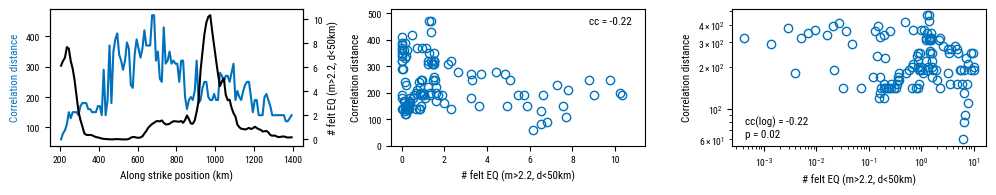

In [13]:
# Cascadia
# --> Extract
casc_cc_d = casc_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']
casc_n_eq = casc_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km']
casc_n_trm = casc_n_trms[f'dx{dx_bin:d}km']

xmin = casc['parameters']['xmin_bin']
xmax = casc['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
casc_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = 100  # in number of events per year, minimum number of events required for that region to consider enough tremor

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_casc)

    ax.plot(casc_xbin_centers, casc_cc_d, c=c_casc)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(casc_xbin_centers, casc_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(casc_n_eq))
    ax.set_ylim(0, 1.1*np.max(casc_cc_d))
    
    ax.plot(casc_n_eq, casc_cc_d, 'o', mec=c_casc, mfc='none')

    cc_casc = np.corrcoef(casc_n_eq, casc_cc_d)[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_casc:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(casc_n_eq, casc_cc_d, 'o', mec=c_casc, mfc='none')
    
    log10_neq_casc = np.log10(casc_n_eq[np.isfinite(casc_n_eq) & np.isfinite(casc_cc_d)])
    log10_cl_casc = np.log10(casc_cc_d[np.isfinite(casc_n_eq) & np.isfinite(casc_cc_d)])

    cc_log_casc, p_cc_log_casc = pearsonr(log10_neq_casc, log10_cl_casc)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_casc:.2f}\np = {p_cc_log_casc:.2f}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

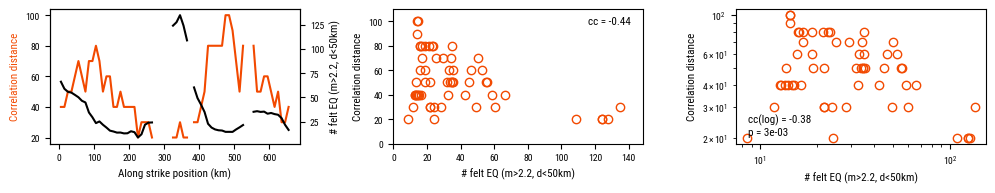

In [14]:
# Nankai (main)
# --> Extract
nank2_cc_d = nank2_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
nank2_n_eq = nank2_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
nank2_n_trm = nank2_n_trms[f'dx{dx_bin:d}km']

xmin = nank2['parameters']['xmin_bin']
xmax = nank2['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
nank2_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = nank2['parameters']['min_n_tremor_dx10km']
nank2_cc_d[nank2_n_trm < n_trm_min] = np.nan
nank2_n_eq[nank2_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_nank2)

    ax.plot(nank2_xbin_centers, nank2_cc_d, c=c_nank2)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(nank2_xbin_centers, nank2_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(nank2_n_eq[~np.isnan(nank2_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(nank2_cc_d[~np.isnan(nank2_cc_d)]))
    
    ax.plot(nank2_n_eq, nank2_cc_d, 'o', mec=c_nank2, mfc='none')

    cc_nank2 = np.corrcoef(nank2_n_eq[np.isfinite(nank2_n_eq) & np.isfinite(nank2_cc_d)], nank2_cc_d[np.isfinite(nank2_n_eq) & np.isfinite(nank2_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_nank2:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(nank2_n_eq, nank2_cc_d, 'o', mec=c_nank2, mfc='none')
    
    log10_neq_nank2 = np.log10(nank2_n_eq[np.isfinite(nank2_n_eq) & np.isfinite(nank2_cc_d)])
    log10_cl_nank2 = np.log10(nank2_cc_d[np.isfinite(nank2_n_eq) & np.isfinite(nank2_cc_d)])

    cc_log_nank2, p_cc_log_nank2 = pearsonr(log10_neq_nank2, log10_cl_nank2)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_nank2:.2f}\np = {p_cc_log_nank2:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

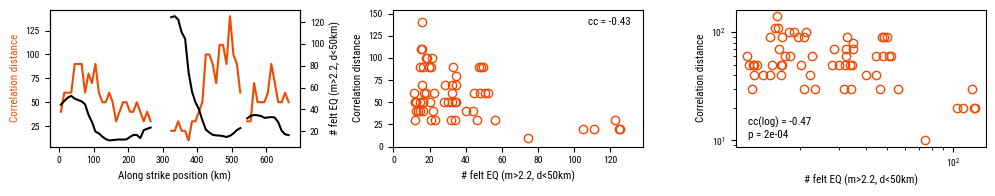

In [15]:
# Nankai (secondary)
# --> Extract
nank_cc_d = nank_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
nank_n_eq = nank_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
nank_n_trm = nank_n_trms[f'dx{dx_bin:d}km']

xmin = nank['parameters']['xmin_bin']
xmax = nank['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
nank_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = nank['parameters']['min_n_tremor_dx10km']
nank_cc_d[nank_n_trm < n_trm_min] = np.nan
nank_n_eq[nank_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_nank)

    ax.plot(nank_xbin_centers, nank_cc_d, c=c_nank)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(nank_xbin_centers, nank_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(nank_n_eq[~np.isnan(nank_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(nank_cc_d[~np.isnan(nank_cc_d)]))
    
    ax.plot(nank_n_eq, nank_cc_d, 'o', mec=c_nank, mfc='none')

    cc_nank = np.corrcoef(nank_n_eq[np.isfinite(nank_n_eq) & np.isfinite(nank_cc_d)], nank_cc_d[np.isfinite(nank_n_eq) & np.isfinite(nank_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_nank:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(nank_n_eq, nank_cc_d, 'o', mec=c_nank, mfc='none')
    
    log10_neq_nank = np.log10(nank_n_eq[np.isfinite(nank_n_eq) & np.isfinite(nank_cc_d)])
    log10_cl_nank = np.log10(nank_cc_d[np.isfinite(nank_n_eq) & np.isfinite(nank_cc_d)])
    cc_log_nank, p_cc_log_nank = pearsonr(log10_neq_nank, log10_cl_nank)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_nank:.2f}\np = {p_cc_log_nank:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

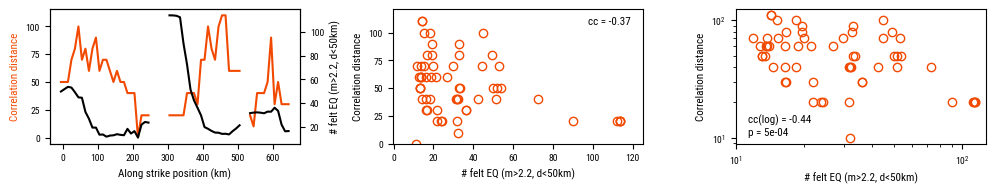

In [16]:
# Nankai (LFEs)
# --> Extract
nank_lfe_cc_d = nank_lfe_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
nank_lfe_n_eq = nank_lfe_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
nank_lfe_n_trm = nank_lfe_n_trms[f'dx{dx_bin:d}km']

xmin = nank_lfe['parameters']['xmin_bin']
xmax = nank_lfe['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
nank_lfe_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = nank_lfe['parameters']['min_n_tremor_dx10km']
nank_lfe_cc_d[nank_lfe_n_trm < n_trm_min] = np.nan
nank_lfe_n_eq[nank_lfe_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_nank_lfe)

    ax.plot(nank_lfe_xbin_centers, nank_lfe_cc_d, c=c_nank_lfe)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(nank_lfe_xbin_centers, nank_lfe_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(nank_lfe_n_eq[~np.isnan(nank_lfe_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(nank_lfe_cc_d[~np.isnan(nank_lfe_cc_d)]))
    
    ax.plot(nank_lfe_n_eq, nank_lfe_cc_d, 'o', mec=c_nank_lfe, mfc='none')

    cc_nank_lfe = np.corrcoef(nank_lfe_n_eq[np.isfinite(nank_lfe_n_eq) & np.isfinite(nank_lfe_cc_d)], nank_lfe_cc_d[np.isfinite(nank_lfe_n_eq) & np.isfinite(nank_lfe_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_nank_lfe:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(nank_lfe_n_eq, nank_lfe_cc_d, 'o', mec=c_nank_lfe, mfc='none')
    
    log10_neq_nank_lfe = np.log10(nank_lfe_n_eq[np.isfinite(nank_lfe_n_eq) & np.isfinite(nank_lfe_cc_d) & (nank_lfe_cc_d > 0)])
    log10_cl_nank_lfe = np.log10(nank_lfe_cc_d[np.isfinite(nank_lfe_n_eq) & np.isfinite(nank_lfe_cc_d) & (nank_lfe_cc_d > 0)])
    cc_log_nank_lfe, p_cc_log_nank_lfe = pearsonr(log10_neq_nank_lfe, log10_cl_nank_lfe)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_nank_lfe:.2f}\np = {p_cc_log_nank_lfe:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

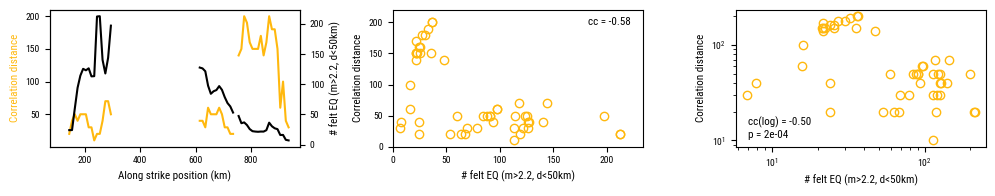

In [17]:
# Japan Trench
# --> Extract
jpt_cc_d = jpt_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
jpt_n_eq = jpt_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
jpt_n_trm = jpt_n_trms[f'dx{dx_bin:d}km']

xmin = jpt['parameters']['xmin_bin']
xmax = jpt['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
jpt_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = jpt['parameters']['min_n_tremor_dx10km']
jpt_cc_d[jpt_n_trm < n_trm_min] = np.nan
jpt_n_eq[jpt_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_jpt)

    ax.plot(jpt_xbin_centers, jpt_cc_d, c=c_jpt)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(jpt_xbin_centers, jpt_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(jpt_n_eq[~np.isnan(jpt_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(jpt_cc_d[~np.isnan(jpt_cc_d)]))
    
    ax.plot(jpt_n_eq, jpt_cc_d, 'o', mec=c_jpt, mfc='none')

    cc_jpt = np.corrcoef(jpt_n_eq[np.isfinite(jpt_n_eq) & np.isfinite(jpt_cc_d)], jpt_cc_d[np.isfinite(jpt_n_eq) & np.isfinite(jpt_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_jpt:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(jpt_n_eq, jpt_cc_d, 'o', mec=c_jpt, mfc='none')
    
    log10_neq_jpt = np.log10(jpt_n_eq[np.isfinite(jpt_n_eq) & np.isfinite(jpt_cc_d)])
    log10_cl_jpt = np.log10(jpt_cc_d[np.isfinite(jpt_n_eq) & np.isfinite(jpt_cc_d)])
    cc_log_jpt, p_cc_log_jpt = pearsonr(log10_neq_jpt, log10_cl_jpt)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_jpt:.2f}\np = {p_cc_log_jpt:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

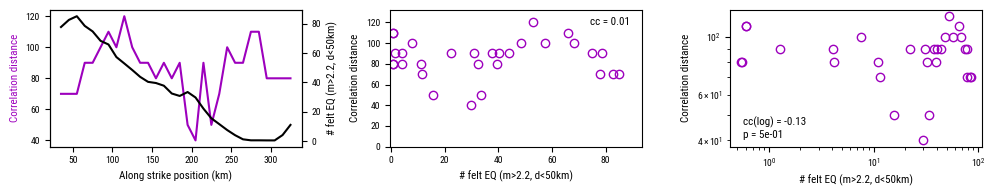

In [18]:
# Alaska
# --> Extract
ak_cc_d = ak_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
ak_n_eq = ak_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
ak_n_trm = ak_n_trms[f'dx{dx_bin:d}km']

xmin = ak['parameters']['xmin_bin']
xmax = ak['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
ak_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = ak['parameters']['min_n_tremor_dx10km']
ak_cc_d[ak_n_trm < n_trm_min] = np.nan
ak_n_eq[ak_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_ak)

    ax.plot(ak_xbin_centers, ak_cc_d, c=c_ak)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(ak_xbin_centers, ak_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(ak_n_eq[~np.isnan(ak_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(ak_cc_d[~np.isnan(ak_cc_d)]))
    
    ax.plot(ak_n_eq, ak_cc_d, 'o', mec=c_ak, mfc='none')

    cc_ak = np.corrcoef(ak_n_eq[np.isfinite(ak_n_eq) & np.isfinite(ak_cc_d)], ak_cc_d[np.isfinite(ak_n_eq) & np.isfinite(ak_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_ak:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(ak_n_eq, ak_cc_d, 'o', mec=c_ak, mfc='none')
    
    log10_neq_ak = np.log10(ak_n_eq[np.isfinite(ak_n_eq) & np.isfinite(ak_cc_d)])
    log10_cl_ak = np.log10(ak_cc_d[np.isfinite(ak_n_eq) & np.isfinite(ak_cc_d)])
    cc_log_ak, p_cc_log_ak = pearsonr(log10_neq_ak, log10_cl_ak)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_ak:.2f}\np = {p_cc_log_ak:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

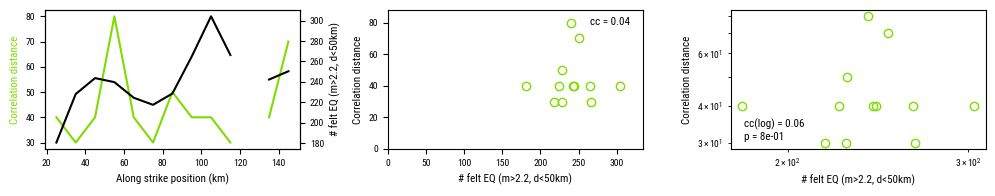

In [19]:
# Hikurangi
# --> Extract
nz_cc_d = nz_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
nz_n_eq = nz_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
nz_n_trm = nz_n_trms[f'dx{dx_bin:d}km']

xmin = nz['parameters']['xmin_bin']
xmax = nz['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
nz_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = nz['parameters']['min_n_tremor_dx10km']
nz_cc_d[nz_n_trm < n_trm_min] = np.nan
nz_n_eq[nz_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_nz)

    ax.plot(nz_xbin_centers, nz_cc_d, c=c_nz)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(nz_xbin_centers, nz_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(nz_n_eq[~np.isnan(nz_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(nz_cc_d[~np.isnan(nz_cc_d)]))
    
    ax.plot(nz_n_eq, nz_cc_d, 'o', mec=c_nz, mfc='none')

    cc_nz = np.corrcoef(nz_n_eq[np.isfinite(nz_n_eq) & np.isfinite(nz_cc_d)], nz_cc_d[np.isfinite(nz_n_eq) & np.isfinite(nz_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_nz:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(nz_n_eq, nz_cc_d, 'o', mec=c_nz, mfc='none')
    
    log10_neq_nz = np.log10(nz_n_eq[np.isfinite(nz_n_eq) & np.isfinite(nz_cc_d)])
    log10_cl_nz = np.log10(nz_cc_d[np.isfinite(nz_n_eq) & np.isfinite(nz_cc_d)])
    cc_log_nz, p_cc_log_nz = pearsonr(log10_neq_nz, log10_cl_nz)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_nz:.2f}\np = {p_cc_log_nz:.0e}', transform=ax.transAxes, va='bottom', ha='left')

    plt.tight_layout()
    plt.show()

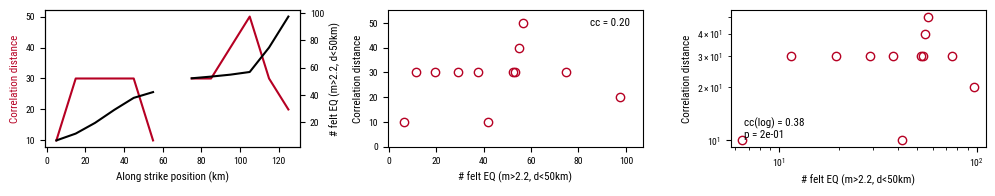

In [20]:
# Parkfield
# --> Extract
pk_cc_d = pk_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
pk_n_eq = pk_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
pk_n_trm = pk_n_trms[f'dx{dx_bin:d}km']

xmin = pk['parameters']['xmin_bin']
xmax = pk['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
pk_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = pk['parameters']['min_n_tremor_dx10km']
pk_cc_d[pk_n_trm < n_trm_min] = np.nan
pk_n_eq[pk_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_pk)

    ax.plot(pk_xbin_centers, pk_cc_d, c=c_pk)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(pk_xbin_centers, pk_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(pk_n_eq[~np.isnan(pk_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(pk_cc_d[~np.isnan(pk_cc_d)]))
    
    ax.plot(pk_n_eq, pk_cc_d, 'o', mec=c_pk, mfc='none')

    cc_pk = np.corrcoef(pk_n_eq[np.isfinite(pk_n_eq) & np.isfinite(pk_cc_d)], pk_cc_d[np.isfinite(pk_n_eq) & np.isfinite(pk_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_pk:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(pk_n_eq, pk_cc_d, 'o', mec=c_pk, mfc='none')
    
    log10_neq_pk = np.log10(pk_n_eq[np.isfinite(pk_n_eq) & np.isfinite(pk_cc_d)])
    log10_cl_pk = np.log10(pk_cc_d[np.isfinite(pk_n_eq) & np.isfinite(pk_cc_d)])
    
    cc_log_pk, p_cc_log_pk = pearsonr(log10_neq_pk, log10_cl_pk)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_pk:.2f}\np = {p_cc_log_pk:.0e}', transform=ax.transAxes, va='bottom', ha='left')


    plt.tight_layout()
    plt.show()

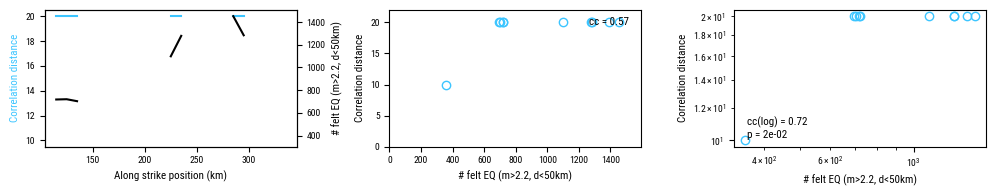

In [21]:
# Taiwan
# --> Extract
tw_cc_d = tw_corr_lengths[f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
tw_n_eq = tw_n_eqs[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{dist:d}km'].copy()
tw_n_trm = tw_n_trms[f'dx{dx_bin:d}km']

xmin = tw['parameters']['xmin_bin']
xmax = tw['parameters']['xmax_bin']
xbin_edges = np.arange(xmin, xmax+dx_bin, dx_bin)
tw_xbin_centers = (xbin_edges[1:] + xbin_edges[:-1])/2

# --> Ignore bins with not enough tremor each year
n_trm_min = tw['parameters']['min_n_tremor_dx10km']
tw_cc_d[tw_n_trm < n_trm_min] = np.nan
tw_n_eq[tw_n_trm < n_trm_min] = np.nan

# --> Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    # Along-strike
    ax = axes[0]
    ax.set_xlabel('Along strike position (km)')
    ax.set_ylabel('Correlation distance', c=c_tw)

    ax.plot(tw_xbin_centers, tw_cc_d, c=c_tw)

    ax_ = ax.twinx()
    ax_.set_ylabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax_.plot(tw_xbin_centers, tw_n_eq, c='k')

    # Against each other
    ax = axes[1]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    ax.set_xlim(-0.5, 1.1*np.max(tw_n_eq[~np.isnan(tw_n_eq)]))
    ax.set_ylim(0, 1.1*np.max(tw_cc_d[~np.isnan(tw_cc_d)]))
    
    ax.plot(tw_n_eq, tw_cc_d, 'o', mec=c_tw, mfc='none')

    cc_tw = np.corrcoef(tw_n_eq[np.isfinite(tw_n_eq) & np.isfinite(tw_cc_d)], tw_cc_d[np.isfinite(tw_n_eq) & np.isfinite(tw_cc_d)])[1, 0]
    ax.text(0.95, 0.95, f'cc = {cc_tw:.2f}', transform=ax.transAxes, va='top', ha='right')

    # Against each other (log-log)
    ax = axes[2]
    ax.set_xlabel(f'# felt EQ (m>{min_mag:.1f}, d<{dist:d}km)')
    ax.set_ylabel('Correlation distance')
    
    ax.loglog(tw_n_eq, tw_cc_d, 'o', mec=c_tw, mfc='none')
    
    log10_neq_tw = np.log10(tw_n_eq[np.isfinite(tw_n_eq) & np.isfinite(tw_cc_d)])
    log10_cl_tw = np.log10(tw_cc_d[np.isfinite(tw_n_eq) & np.isfinite(tw_cc_d)])
    cc_log_tw, p_cc_log_tw = pearsonr(log10_neq_tw, log10_cl_tw)
    ax.text(0.05, 0.05, f'cc(log) = {cc_log_tw:.2f}\np = {p_cc_log_tw:.0e}', transform=ax.transAxes, va='bottom', ha='left')
    plt.tight_layout()
    plt.show()

## 2.2. <a id='toc2_2_'></a>Global   [&#128285;](#toc0_)

In [22]:
# Parameters
add_ellipses = True
n_std = 1
lw = 1.3
alpha = .1
ms = 6
ms_inset = 3

c_casc_light = light_C0 = '#9fd9ff'
c_nank_light = c_nank2_light = light_C1 = '#ffc7af'
c_jpt_light = light_C2 = '#ffeab7'
c_ak_light = light_C3 = '#ef9fff'
c_nz_light = light_C4 = '#daffa8'
c_pk_light = light_C5 = '#ff7c95'
c_tw_light = light_C6 = '#b1e8ff'

In [23]:
# Load simulation?
sim_num = 2
path = "../simulations/np_osc_{:d}.pkl".format(sim_num)
print("Loading", path)

sim = pickle.load(open(path, "rb"))
sim_param = sim['parameters']
sim_results = sim['results']

ev_x = np.array(sim_results['firing_idx'])*sim_param['length_scale']
ev_t = np.array(sim_results['firing_times'])*sim_param['time_scale']
corr_length = sim_results['corr_length']

perturbation_idx = sim_results['perturbation_idx']
perturbation_times = sim_results['perturbation_times']
spatial_perturbation_yearly = sim_results['spatial_perturbation_yearly']

Loading ../simulations/np_osc_2.pkl


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_4564/3527357891.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


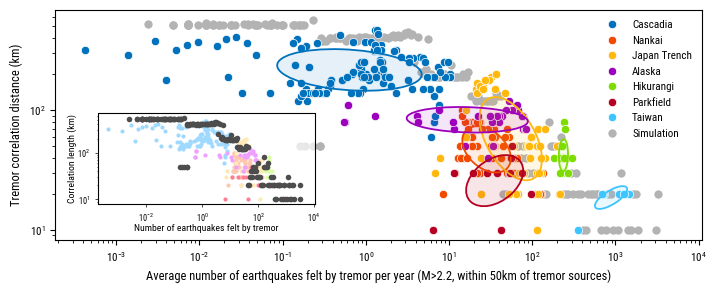

In [24]:
# General plot
with plt.style.context('grl'):
    with plt.rc_context({'font.size': 9, 'axes.labelsize': 9, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8}):
        fig, ax = plt.subplots(figsize=(7.24, 3))

        ax.set_xlabel(f'Average number of earthquakes felt by tremor per year (M>{min_mag:.1f}, within {dist:d}km of tremor sources)')
        ax.set_ylabel('Tremor correlation distance (km)')

        ax.loglog(casc_n_eq, casc_cc_d, 'o', ms=ms, mfc=c_casc, mec='w', mew=.5, label='Cascadia')
        ax.loglog(nank2_n_eq, nank2_cc_d, 'o', ms=ms, mfc=c_nank2, mec='w', mew=.5, label='Nankai')
        # ax.loglog(nank_n_eq, nank_cc_d, 'o', mfc=c_nank, mec='w', mew=.5, label='Nankai (secondary)')
        ax.loglog(jpt_n_eq, jpt_cc_d, 'o', ms=ms, mfc=c_jpt, mec='w', mew=.5, label='Japan Trench')
        ax.loglog(ak_n_eq, ak_cc_d, 'o', ms=ms, mfc=c_ak, mec='w', mew=.5, label='Alaska')
        ax.loglog(nz_n_eq, nz_cc_d, 'o', ms=ms, mfc=c_nz, mec='w', mew=.5, label='Hikurangi')
        ax.loglog(pk_n_eq, pk_cc_d, 'o', ms=ms, mfc=c_pk, mec='w', mew=.5, label='Parkfield')
        ax.loglog(tw_n_eq, tw_cc_d, 'o', ms=ms, mfc=c_tw, mec='w', mew=.5, label='Taiwan')

        ax.loglog(spatial_perturbation_yearly, corr_length, 'o', ms=ms, mfc='.7', mec='none', zorder=-1, label='Simulation')

        plt.tight_layout()

        # Add ellipses
        if add_ellipses:
            # duplicate axis
            ax_twin = fig.add_axes(ax.get_position())
            ax_twin.set_xlim(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]))
            ax_twin.set_ylim(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]))
            ax_twin.axis('off')

            confidence_ellipse(np.log10(casc_n_eq), np.log10(casc_cc_d), ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_casc, facecolor=to_rgba(c_casc, alpha))
            confidence_ellipse(log10_neq_nank2, log10_cl_nank2, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_nank2, facecolor=to_rgba(c_nank2, alpha))
            confidence_ellipse(log10_neq_jpt, log10_cl_jpt, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_jpt, facecolor=to_rgba(c_jpt, alpha))
            confidence_ellipse(log10_neq_ak, log10_cl_ak, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_ak, facecolor=to_rgba(c_ak, alpha))
            confidence_ellipse(log10_neq_nz, log10_cl_nz, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_nz, facecolor=to_rgba(c_nz, alpha))
            confidence_ellipse(log10_neq_pk, log10_cl_pk, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_pk, facecolor=to_rgba(c_pk, alpha))
            confidence_ellipse(log10_neq_tw, log10_cl_tw, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_tw, facecolor=to_rgba(c_tw, alpha))
            
        plt.tight_layout()
        
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
        
        # Inset axis
        with plt.rc_context({'font.size': 7, 'axes.labelsize': 7, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
            ax_inset = fig.add_axes([.14, .31, .3, .3])
            ax_inset.patch.set_alpha(.7)
            ax_inset.set_xscale('log')
            ax_inset.set_yscale('log')

            ax_inset.set_xlabel('Number of earthquakes felt by tremor', labelpad=0)
            ax_inset.set_ylabel('Correlation length (km)', labelpad=0)
            # shrink tick length
            ax_inset.tick_params(axis='both', which='major', length=2, width=.5)
            ax_inset.tick_params(axis='both', which='minor', length=1, width=.5)


            ax_inset.loglog(casc_n_eq, casc_cc_d, 'o', ms=ms_inset, mfc=c_casc_light, mec='none')
            ax_inset.loglog(nank2_n_eq, nank2_cc_d, 'o', ms=ms_inset, mfc=c_nank2_light, mec='none')
            ax_inset.loglog(jpt_n_eq, jpt_cc_d, 'o', ms=ms_inset, mfc=c_jpt_light, mec='none')
            ax_inset.loglog(ak_n_eq, ak_cc_d, 'o', ms=ms_inset, mfc=c_ak_light, mec='none')
            ax_inset.loglog(nz_n_eq, nz_cc_d, 'o', ms=ms_inset, mfc=c_nz_light, mec='none')
            ax_inset.loglog(pk_n_eq, pk_cc_d, 'o', ms=ms_inset, mfc=c_pk_light, mec='none')
            ax_inset.loglog(tw_n_eq, tw_cc_d, 'o', ms=ms_inset, mfc=c_tw_light, mec='none')
            
            ax_inset.loglog(spatial_perturbation_yearly, corr_length, 'o', ms=ms_inset+1, mfc='.3', mec='none', label='Simulation')

        plt.savefig('../figures/global_results.png', dpi=300, bbox_inches='tight')
        plt.savefig('../figures/global_results.pdf', dpi=300, bbox_inches='tight')
        plt.show()

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_4564/3553408721.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


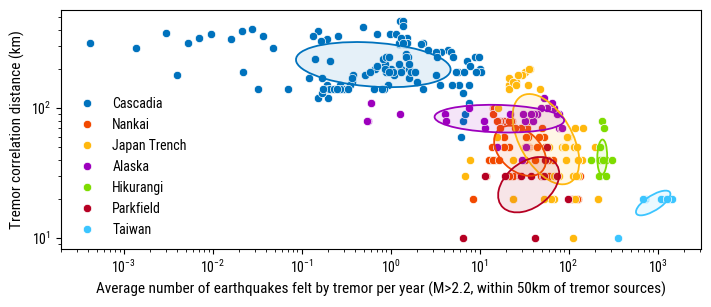

In [25]:
# General plot (tweaking version)
with plt.style.context('grl'):
    with plt.rc_context({'font.size': 11, 'axes.labelsize': 11, 'legend.fontsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10}):
        fig, ax = plt.subplots(figsize=(7.24, 3.2))

        ax.set_xlabel(f'Average number of earthquakes felt by tremor per year (M>{min_mag:.1f}, within {dist:d}km of tremor sources)')
        ax.set_ylabel('Tremor correlation distance (km)')

        ax.loglog(casc_n_eq, casc_cc_d, 'o', ms=ms, mfc=c_casc, mec='w', mew=.5, label='Cascadia')
        ax.loglog(nank2_n_eq, nank2_cc_d, 'o', ms=ms, mfc=c_nank2, mec='w', mew=.5, label='Nankai')
        # ax.loglog(nank_n_eq, nank_cc_d, 'o', mfc=c_nank, mec='w', mew=.5, label='Nankai (secondary)')
        ax.loglog(jpt_n_eq, jpt_cc_d, 'o', ms=ms, mfc=c_jpt, mec='w', mew=.5, label='Japan Trench')
        ax.loglog(ak_n_eq, ak_cc_d, 'o', ms=ms, mfc=c_ak, mec='w', mew=.5, label='Alaska')
        ax.loglog(nz_n_eq, nz_cc_d, 'o', ms=ms, mfc=c_nz, mec='w', mew=.5, label='Hikurangi')
        ax.loglog(pk_n_eq, pk_cc_d, 'o', ms=ms, mfc=c_pk, mec='w', mew=.5, label='Parkfield')
        ax.loglog(tw_n_eq, tw_cc_d, 'o', ms=ms, mfc=c_tw, mec='w', mew=.5, label='Taiwan')

        # ax.loglog(spatial_perturbation_yearly, corr_length, 'o', ms=ms, mfc='.7', mec='none', zorder=-1, label='Simulation')

        plt.tight_layout()

        # Add ellipses
        if add_ellipses:
            # duplicate axis
            ax_twin = fig.add_axes(ax.get_position())
            ax_twin.set_xlim(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]))
            ax_twin.set_ylim(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]))
            ax_twin.axis('off')

            confidence_ellipse(np.log10(casc_n_eq), np.log10(casc_cc_d), ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_casc, facecolor=to_rgba(c_casc, alpha))
            confidence_ellipse(log10_neq_nank2, log10_cl_nank2, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_nank2, facecolor=to_rgba(c_nank2, alpha))
            confidence_ellipse(log10_neq_jpt, log10_cl_jpt, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_jpt, facecolor=to_rgba(c_jpt, alpha))
            confidence_ellipse(log10_neq_ak, log10_cl_ak, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_ak, facecolor=to_rgba(c_ak, alpha))
            confidence_ellipse(log10_neq_nz, log10_cl_nz, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_nz, facecolor=to_rgba(c_nz, alpha))
            confidence_ellipse(log10_neq_pk, log10_cl_pk, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_pk, facecolor=to_rgba(c_pk, alpha))
            confidence_ellipse(log10_neq_tw, log10_cl_tw, ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=c_tw, facecolor=to_rgba(c_tw, alpha))
            
        plt.tight_layout()
        ax.legend(loc='lower left', frameon=False)
        
        
        # # Inset axis
        # with plt.rc_context({'font.size': 7, 'axes.labelsize': 7, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
        #     ax_inset = fig.add_axes([.14, .31, .3, .3])
        #     ax_inset.patch.set_alpha(.7)
        #     ax_inset.set_xscale('log')
        #     ax_inset.set_yscale('log')

        #     ax_inset.set_xlabel('Number of earthquakes felt by tremor', labelpad=0)
        #     ax_inset.set_ylabel('Correlation length (km)', labelpad=0)
        #     # shrink tick length
        #     ax_inset.tick_params(axis='both', which='major', length=2, width=.5)
        #     ax_inset.tick_params(axis='both', which='minor', length=1, width=.5)


        #     ax_inset.loglog(casc_n_eq, casc_cc_d, 'o', ms=ms_inset, mfc=c_casc_light, mec='none')
        #     ax_inset.loglog(nank2_n_eq, nank2_cc_d, 'o', ms=ms_inset, mfc=c_nank2_light, mec='none')
        #     ax_inset.loglog(jpt_n_eq, jpt_cc_d, 'o', ms=ms_inset, mfc=c_jpt_light, mec='none')
        #     ax_inset.loglog(ak_n_eq, ak_cc_d, 'o', ms=ms_inset, mfc=c_ak_light, mec='none')
        #     ax_inset.loglog(nz_n_eq, nz_cc_d, 'o', ms=ms_inset, mfc=c_nz_light, mec='none')
        #     ax_inset.loglog(pk_n_eq, pk_cc_d, 'o', ms=ms_inset, mfc=c_pk_light, mec='none')
        #     ax_inset.loglog(tw_n_eq, tw_cc_d, 'o', ms=ms_inset, mfc=c_tw_light, mec='none')
            
        #     ax_inset.loglog(spatial_perturbation_yearly, corr_length, 'o', ms=ms_inset+1, mfc='.3', mec='none', label='Simulation')

        plt.savefig('../figures/global_results_tweaked.png', dpi=300, bbox_inches='tight')
        plt.show()

# 3. <a id='toc3_'></a>Compute correlation coefficient with uncertainty using bootstrapping  [&#128285;](#toc0_)

In [26]:
# Fit multivariate normal to each region, resample and get estimates of the coefficient of correlation
n_boot = 10000  # number of new samples per region

# --> Fit
mean_casc, cov_casc = multivariate_normal.fit(np.vstack([log10_neq_casc, log10_cl_casc]).T)
mean_nank2, cov_nank2 = multivariate_normal.fit(np.vstack([log10_neq_nank2, log10_cl_nank2]).T)
mean_jpt, cov_jpt = multivariate_normal.fit(np.vstack([log10_neq_jpt, log10_cl_jpt]).T)
mean_pk, cov_pk = multivariate_normal.fit(np.vstack([log10_neq_pk, log10_cl_pk]).T)
mean_tw, cov_tw = multivariate_normal.fit(np.vstack([log10_neq_tw, log10_cl_tw]).T)
mean_nz, cov_nz = multivariate_normal.fit(np.vstack([log10_neq_nz, log10_cl_nz]).T)
mean_ak, cov_ak = multivariate_normal.fit(np.vstack([log10_neq_ak, log10_cl_ak]).T)

# --> Resample
casc_boot = multivariate_normal.rvs(mean_casc, cov_casc, size=n_boot)
nank2_boot = multivariate_normal.rvs(mean_nank2, cov_nank2, size=n_boot)
jpt_boot = multivariate_normal.rvs(mean_jpt, cov_jpt, size=n_boot)
pk_boot = multivariate_normal.rvs(mean_pk, cov_pk, size=n_boot)
tw_boot = multivariate_normal.rvs(mean_tw, cov_tw, size=n_boot)
nz_boot = multivariate_normal.rvs(mean_nz, cov_nz, size=n_boot)
ak_boot = multivariate_normal.rvs(mean_ak, cov_ak, size=n_boot)

# --> Get estimates of the coefficient of correlation
cc_global_boot = np.zeros(n_boot)

for ii in range(n_boot):
    neq = np.array([casc_boot[ii, 0], nank2_boot[ii, 0], jpt_boot[ii, 0], pk_boot[ii, 0], tw_boot[ii, 0], nz_boot[ii, 0], ak_boot[ii, 0]])
    cl = np.array([casc_boot[ii, 1], nank2_boot[ii, 1], jpt_boot[ii, 1], pk_boot[ii, 1], tw_boot[ii, 1], nz_boot[ii, 1], ak_boot[ii, 1]])
    cc_global_boot[ii] = np.corrcoef(neq, cl)[0, 1]

print(f'Global correlation coefficient: {np.mean(cc_global_boot):.3f} +/- {2*np.std(cc_global_boot):.3f} (95% CI)')

Global correlation coefficient: -0.745 +/- 0.311 (95% CI)


# 4. <a id='toc4_'></a>Compute correlation coefficients for all sets of parameters [&#128285;](#toc0_)

In [27]:
# Sets of parameters
min_mags = [1., 1.5, 1.8, 2., 2.2, 2.4]
max_dists = [10, 20, 30, 50, 100]

cc_thrs = [0.05, 0.07, 0.1]
v_mins = [1., 3.5, 10.]
dx_bins = [5, 10]

regions = ['casc', 'nank2', 'jpt', 'pk', 'tw', 'nz', 'ak']
eqs = [casc_n_eqs, nank2_n_eqs, jpt_n_eqs, pk_n_eqs, tw_n_eqs, nz_n_eqs, ak_n_eqs]
ccs = [casc_corr_lengths, nank2_corr_lengths, jpt_corr_lengths, pk_corr_lengths, tw_corr_lengths, nz_corr_lengths, ak_corr_lengths]
n_trms = [casc_n_trms, nank2_n_trms, jpt_n_trms, pk_n_trms, tw_n_trms, nz_n_trms, ak_n_trms]
n_trm_mins = [casc['parameters']['min_n_tremor_dx10km'], nank2['parameters']['min_n_tremor_dx10km'], jpt['parameters']['min_n_tremor_dx10km'], pk['parameters']['min_n_tremor_dx10km'], tw['parameters']['min_n_tremor_dx10km'], nz['parameters']['min_n_tremor_dx10km'], ak['parameters']['min_n_tremor_dx10km']]

n_tot = len(min_mags)*len(max_dists)*len(cc_thrs)*len(v_mins)*len(dx_bins)
print(f'Total number of combinations: {n_tot}')

Total number of combinations: 540


In [28]:
# Loop over all combinations
results = {}

ii = 0

for dx_bin in dx_bins:
    results[f'dx{dx_bin:d}km'] = {}
    for min_mag in min_mags:
        results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'] = {}
        for max_dist in max_dists:
            results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'] = {}
            for v_min in v_mins:
                results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'] = {}
                for cc_thr in cc_thrs:
                    results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'] = {}
                    # Regional results
                    for region in regions:
                        region_dict = results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region] = {}

                        # extract
                        cc_d = ccs[regions.index(region)][f'dx{dx_bin:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'].copy()
                        n_eq = eqs[regions.index(region)][f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'].copy()
                        n_trm = n_trms[regions.index(region)][f'dx{dx_bin:d}km']
                        n_trm_min = n_trm_mins[regions.index(region)]

                        # ignore bins with not enough tremor each year
                        cc_d[n_trm < n_trm_min/(dx_bin/10)] = np.nan
                        n_eq[n_trm < n_trm_min/(dx_bin/10)] = np.nan

                        # compute log-cc
                        log10_neq = np.log10(n_eq[np.isfinite(n_eq) & np.isfinite(cc_d) & (cc_d > 0) & (n_eq > 0)])
                        log10_cl = np.log10(cc_d[np.isfinite(n_eq) & np.isfinite(cc_d) & (cc_d > 0) & (n_eq > 0)])
                        cc_log = np.corrcoef(log10_neq, log10_cl)[0, 1]

                        region_dict['cc_log'] = cc_log
                        region_dict['cc_d'] = cc_d
                        region_dict['n_eq'] = n_eq

                        # Fit multivariate
                        mean, cov = multivariate_normal.fit(np.vstack([log10_neq, log10_cl]).T)
                        region_dict['fit_mean'] = mean
                        region_dict['fit_cov'] = cov

                    # Global results
                    n_boot = 10000  # number of new samples per region

                    # --> Fit multivariate normal to each region, resample and compute correlation coefficient
                    cc_global_boot = np.zeros(n_boot)

                    region_means = np.array([results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['fit_mean'] for region in regions])
                    region_covs = np.array([results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['fit_cov'] for region in regions])

                    region_samples = np.array([multivariate_normal.rvs(region_means[ii], region_covs[ii], size=n_boot) for ii in range(len(regions))])

                    for jj in range(n_boot):
                        neq = np.array([region_samples[ii, jj, 0] for ii in range(len(regions))])
                        cl = np.array([region_samples[ii, jj, 1] for ii in range(len(regions))])
                        cc_global_boot[jj] = np.corrcoef(neq, cl)[0, 1]
                    
                    results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']['global_cc'] = np.mean(cc_global_boot)
                    results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']['global_cc_std'] = np.std(cc_global_boot)

                    ii += 1
                    print(f'Combination {ii}/{n_tot}', end='\r')

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
# Save results
pickle.dump(results, open('../results/combined_results.pkl', 'wb'))